# Fitting Circles

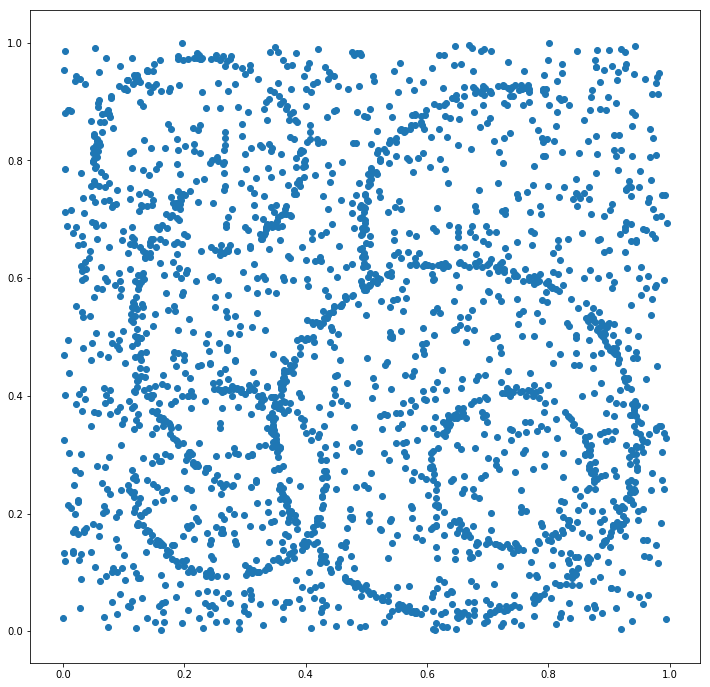

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

data = np.load('circles.npy')

plt.figure(figsize=(12,12))
plt.scatter(data[:,0], data[:,1])
plt.show()

## RANSAC

In [2]:
def find_circle(x, y, z):
    M = 2*np.stack((x-y, y-z))
    t = np.stack((x@x - y@y, y@y - z@z))
    
    c = np.linalg.solve(M, t)
    r = np.linalg.norm(x-c)
    
    return r, c

In [3]:
def ransac(data: np.ndarray, num_circles: int, N: int, epsilon: float):
    radii = []
    centers = []
    
    
    for i in range(num_circles):
        best_inliers = 0
        radius = 0
        center = None
        best_mask = None

        for n in range(N):
            idx = np.random.randint(0, data.shape[0], 3)
            x, y, z = data[idx][0,:], data[idx][1,:], data[idx][2,:]
            if (x[1] - y[1])*(x[0] - z[0]) == (x[1] - z[1])*(x[0] - y[0]):
                continue
            r, c = find_circle(x, y, z)
            d = data - c
            mask = np.abs(np.sum(d**2,axis=-1) - r**2) < epsilon
            
            inliers = np.sum(mask)
            if inliers > best_inliers:
                best_inliers = inliers
                radius = r
                center = c
                best_mask = mask    
       
        radii.append(radius)
        centers.append(center)
        data = data[np.logical_not(best_mask)]
            
    return radii, centers

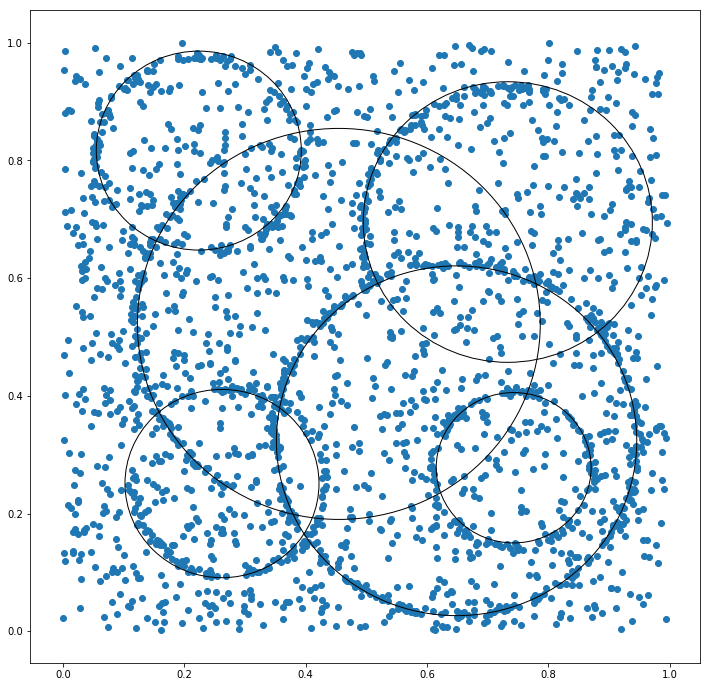

In [4]:
epsilon = 5e-3
radii, centers = ransac(data, 6, 1000, epsilon)

plt.figure(figsize=(12,12))
plt.scatter(data[:,0], data[:,1])

for r, c in zip(radii, centers):
    circle = plt.Circle((c[0], c[1]), radius=r, fill=False) # Create a circle
    plt.gca().add_patch(circle) # Add it to the plot
plt.show()

## Algebraic distance

In [5]:
def fit_algebraic(data):
    X = np.append(data, np.ones((data.shape[0],1)), axis=-1)
    Y = np.sum(data**2, axis=-1)
    
    b = np.linalg.lstsq(X, Y)[0]
    
    c = np.array([b[0], b[1]])/2
    r = np.sqrt(np.sum(c**2) + b[2])
    
    return r, c

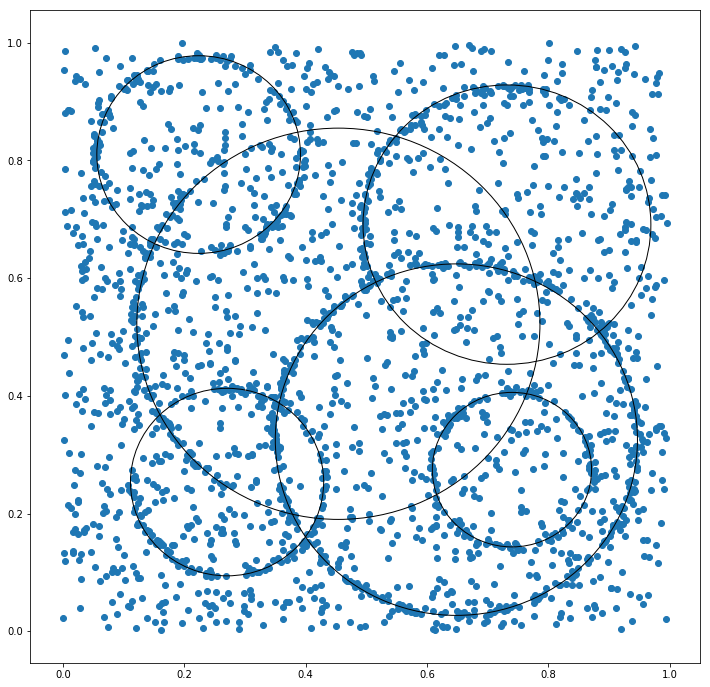

In [6]:
plt.figure(figsize=(12,12))
plt.scatter(data[:,0], data[:,1])
for radius, center in zip(radii, centers):
    d = data - center
    mask = np.abs(np.sum(d**2,axis=-1) - radius**2) < epsilon
    r, c = fit_algebraic(data[mask])
    circle = plt.Circle((c[0], c[1]), radius=r, fill=False) # Create a circle
    plt.gca().add_patch(circle) # Add it to the plot
plt.show()

## Levenberg-Marquardt

The task is to compute
$$
\min\limits_{c, r} \sum\limits_i 
\left( \lVert x_i-c\rVert_2^2-r^2 \right)^2 = \min\limits_{c, r} \sum\limits_i 
\left( r^2 - \lVert x_i-c\rVert_2^2 \right)^2
$$

For this, in order to compute the Jacobian, we need to express $r$ in terms of $x$ and $c$:
$$
r = \sqrt{\lVert x\rVert_2^2-2xc+\lVert c\rVert_2^2}
$$

Then the Jacobian is
$$
\frac{\partial r}{\partial c_i} = \frac{1}{2}\left( \lVert x\rVert_2^2-2xc+\lVert c\rVert_2^2 \right)^{-\frac{1}{2}}\left(2c_i-2x_i\right)
$$

So to apply Levenberg-Marquardt we identify
$$
\begin{align}
Y &= r \\\\
\tilde{Y} &= r - \sqrt{\lVert x\rVert_2^2-2xc+\lVert c\rVert_2^2} \\\\
\tilde{X} &= \frac{\partial r}{\partial c'}\bigg\vert_{c}
\end{align}
$$

And use OLS to compute
$$
\min\limits_\Delta \lVert \tilde{Y} - \tilde{X}\Delta \rVert_2^2
$$

In [8]:
def residuals(x, data):
    return x[0]**2 - np.sum((data-x[1:])**2, axis=-1)

def fit_levmarq(data, x0):
    x = least_squares(residuals, x0, method='lm', args=(data,)).x
    return x[0], x[1:]

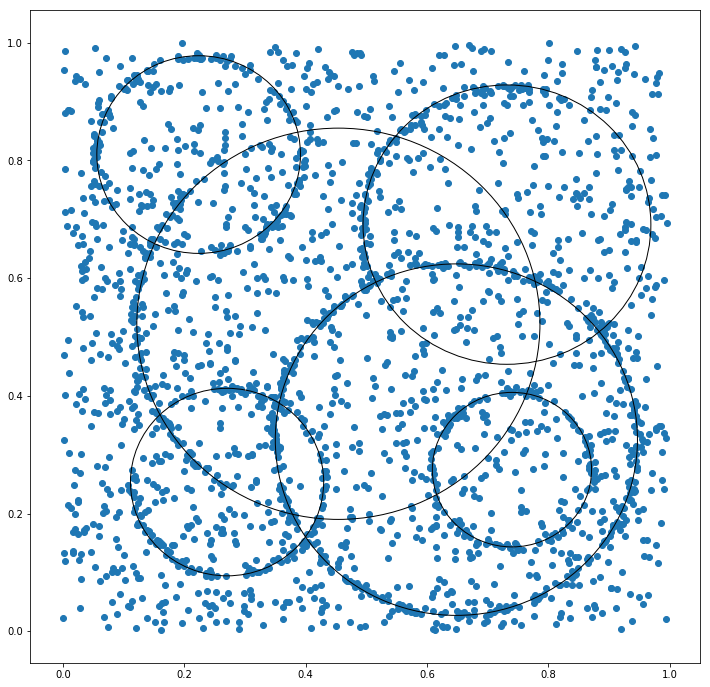

In [9]:
plt.figure(figsize=(12,12))
plt.scatter(data[:,0], data[:,1])
for radius, center in zip(radii, centers):
    d = data - center
    mask = np.abs(np.sum(d**2,axis=-1) - radius**2) < epsilon
    r, c = fit_levmarq(data[mask], np.append(np.array([radius]), center, axis=0))
    circle = plt.Circle((c[0], c[1]), radius=r, fill=False) # Create a circle
    plt.gca().add_patch(circle) # Add it to the plot
plt.show()

## Comparison

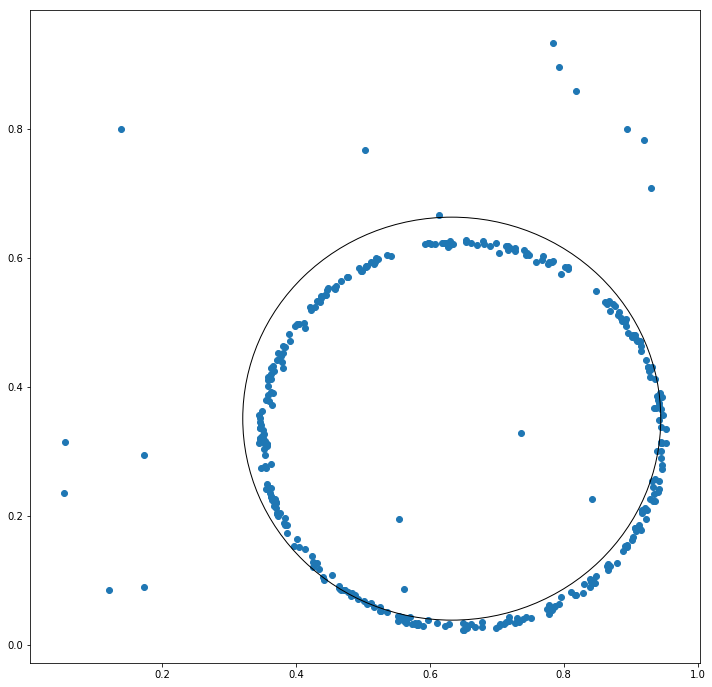

In [12]:
plt.figure(figsize=(12,12))
radius, center = radii[0], centers[0]
d = data - center
outlier_data = np.append(data[mask], np.random.uniform(data[mask].min(), data[mask].max(), (20,2)), axis=0)
mask = np.abs(np.sum(d**2,axis=-1) - radius**2) < epsilon
plt.scatter(outlier_data[:,0], outlier_data[:,1])

r, c = fit_levmarq(outlier_data, np.append(np.array([radius]), center, axis=0))
circle = plt.Circle((c[0], c[1]), radius=r, fill=False) # Create a circle
plt.gca().add_patch(circle) # Add it to the plot

plt.show()